Análisis de performance de agentes - Búsqueda Local
===
# Tiempo de ejecución

In [1]:
import NQueens
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from copy import copy
from time import time_ns

## Se llevará a cabo con la siguiente configuración:

In [2]:
algorithms = [NQueens.hill_climbing, NQueens.simulated_annealing]
sizes = [4, 8, 10, 12, 15]
n_iterations = 30
iter_limit_pow = 3
random.seed(42)

---

# Tiempo de ejecución

## Correr simulación

In [3]:
def run_simulation(simulations, algorithms, size, limit):
    # Create common board
    base_board = random.sample(range(size), size)
    
    # Run in each agent
    for algorithm in algorithms:
        # Run agent
        start = time_ns()
        best_h, iterations, _ = algorithm(copy(base_board), limit)
        end = time_ns()
        
        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'best_h': best_h,
            'iterations': iterations,
            'time_ms': (end-start)/1e6
        })

In [4]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for size in sizes:
        for _ in range(n_iterations):
            pool.apply_async(run_simulation, args=(simulations, algorithms, size, size**iter_limit_pow))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df.to_csv('simulations.csv')
simulations_df

,algorithm,size,best_h,iterations,time_ms
0,hill_climbing,4,0,36,0.663306
1,simulated_annealing,4,0,22,0.343466
2,hill_climbing,4,1,12,0.369767
3,simulated_annealing,4,0,34,0.492557
4,hill_climbing,4,2,12,0.256872
...,...,...,...,...,...
295,simulated_annealing,15,1,3375,101.238667
296,hill_climbing,15,3,1470,35.471471
297,simulated_annealing,15,0,2299,45.713739
298,simulated_annealing,15,1,3375,98.520559


## Análisis del performance de cada algorítmo

In [5]:
samples_list = []

for algorithm in algorithms:
    for size in sizes:
        sample_df = simulations_df.query(f'algorithm == "{algorithm.__name__}" and size == {size}')
        
        # Find optimals
        try:
            optimals = sample_df.best_h.value_counts().loc[0]
        except KeyError:
            optimals = 0
        
        # Save saple report
        samples_list.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'optimal_rate': optimals / n_iterations,
            'time_ms_avg': sample_df['time_ms'].mean(),
            'time_ms_std': sample_df['time_ms'].std(),
            'iter_avg': sample_df['iterations'].mean(),
            'iter_std': sample_df['iterations'].std()
        })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df.to_csv('samples.csv')
samples_df

,algorithm,size,optimal_rate,time_ms_avg,time_ms_std,iter_avg,iter_std
0,hill_climbing,4,0.100000,0.581944,0.421868,27.200000,19.914299
1,hill_climbing,8,0.100000,3.948134,2.401648,205.333333,126.793161
2,hill_climbing,10,0.100000,9.508952,4.951471,450.000000,235.166852
3,hill_climbing,12,0.033333,16.791521,6.583566,748.000000,294.821512
4,hill_climbing,15,0.000000,40.413436,13.273011,1603.000000,518.759462
5,simulated_annealing,4,0.800000,1.004871,0.556304,37.900000,20.529793
6,simulated_annealing,8,0.633333,8.928099,3.924961,358.533333,155.202367
7,simulated_annealing,10,0.500000,20.637921,8.103903,773.166667,287.246270
8,simulated_annealing,12,0.366667,37.576081,14.786870,1357.666667,536.289123
9,simulated_annealing,15,0.700000,70.034147,35.553249,2306.633333,1102.892701


## Gráficos
### Box plot - Tiempo empleado hasta llegar a una solución

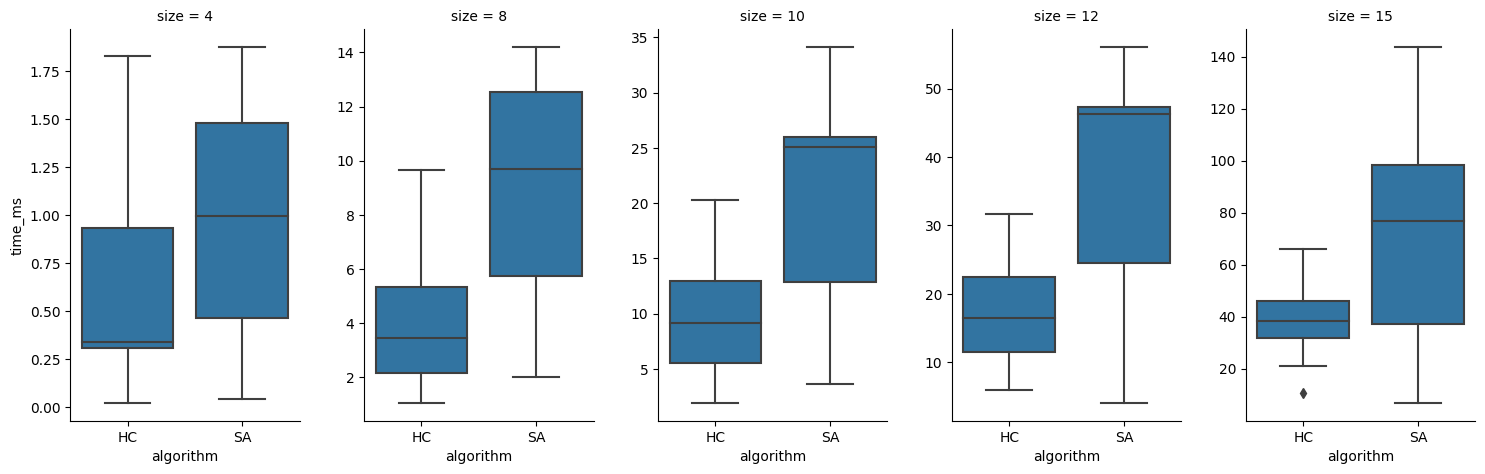

In [6]:
%matplotlib inline

grid1 = sns.FacetGrid(data=simulations_df, col='size', sharey=False)
grid1.map(sns.boxplot, 'algorithm', 'time_ms', order= [x.__name__ for x in algorithms])
grid1.set_xticklabels(['HC', 'SA'])

grid1.fig.subplots_adjust(top=1.5)
grid1.savefig('time_by_algorithm.svg')


# Comportamiento de h()

## Se llevará acabo con la siguiente configuración

In [7]:
size = 24
n_iterations = 3
limit = 50_000

In [8]:
def run_simulation_h(simulations, algorithms, size, limit, i):
    # Create common board
    base_board = random.sample(range(size), size)
    
    # Run in each agent
    for algorithm in algorithms:
        # Run agent
        _, _, h_history = algorithm(copy(base_board), limit)

        # Dump the data to the simulations list
        for step, h in h_history:
            simulations.append({
                'algorithm': algorithm.__name__,
                'board': i,
                'step': step,
                'h': h
            })

In [9]:
with mp.Manager() as manager:
    simulations_h = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Run
    for i in range(n_iterations):
        pool.apply_async(run_simulation_h, args=(simulations_h, algorithms, size, limit, i))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a list
    simulations_h_df = pd.DataFrame(list(simulations_h))

### Lineplot - Comportamiento de h() por algorítmo, en tableros idénticos

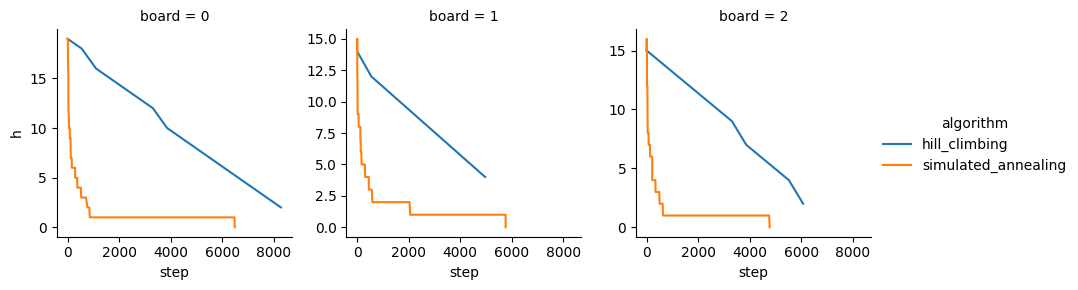

In [10]:
%matplotlib inline

grid2 = sns.FacetGrid(data=simulations_h_df, hue='algorithm', col='board', sharey=False)
grid2.map(sns.lineplot, 'step', 'h')
grid2.add_legend()

grid1.savefig('h-behavior.svg')